# Software analytics: Increase code review speed — impact on global colaboration in large projects

## Imports

In [2]:
! pip install -r requirements.txt

In [3]:
! pip install scipy statsmodels

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.mstats import spearmanr
from scipy.stats import kendalltau, mannwhitneyu, shapiro, kruskal
import scipy.stats as stats
from statsmodels.nonparametric.smoothers_lowess import lowess

## Load data

https://zenodo.org/records/3922907

In [5]:
def load_data():
    data = pd.read_csv('./data/new_pullreq.csv', header=0)
    return data
data = load_data()
data

,id,project_id,ownername,reponame,merged_or_not,lifetime_minutes,mergetime_minutes,num_commits,src_churn,test_churn,...,other_comment,num_comments_con,num_code_comments,num_code_comments_con,integrator_availability,friday_effect,contrib_rate_author,reopen_or_not,first_close_minutes,reopen_num
0,1,13708387,stylelint,stylelint,1,237,237.0,1,0,0,...,0,0,0,0,30.0,1,0.007948,0,237,0
1,2,100297899,Joaogarciadelima,checklistos,0,1410,NaN,1,0,0,...,0,2,0,0,597.0,0,0.830769,0,1410,0
2,3,93139005,binary-com,SmartCharts,1,4,4.0,1,0,0,...,0,0,0,0,2.0,0,0.314368,0,4,0
3,4,15059440,letsencrypt,boulder,1,52,52.0,1,9,104,...,0,0,0,0,1.0,0,0.117332,0,52,0
4,5,29684214,PyCQA,astroid,1,2414,2414.0,1,33,27,...,0,0,0,0,2.0,0,0.010753,0,2414,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3347932,3347933,30544060,Kronos-Integration,kronos-service-consul,1,9,9.0,1,0,0,...,0,0,0,0,2537.0,0,0.696970,0,9,0
3347933,3347934,1142,saltstack,salt,0,1165,NaN,1,10,0,...,0,1,0,0,42.0,0,0.056849,0,1165,0
3347934,3347935,31499094,mjmlio,mjml,1,8834,8834.0,2,6,0,...,0,8,0,0,597.0,0,0.002041,0,8834,0
3347935,3347936,55317,zotonic,zotonic,0,703,NaN,7,15,0,...,0,0,0,0,10.0,0,0.000732,0,703,0


In [6]:
for key in data.keys():
    print(key)

id
project_id
ownername
reponame
merged_or_not
lifetime_minutes
mergetime_minutes
num_commits
src_churn
test_churn
files_added
files_deleted
files_modified
files_changed
src_files
doc_files
other_files
num_commit_comments
num_issue_comments
num_comments
num_participants
sloc
team_size
perc_external_contribs
commits_on_files_touched
test_lines_per_kloc
test_cases_per_kloc
asserts_per_kloc
watchers
prev_pullreqs
requester_succ_rate
followers
churn_addition
churn_deletion
pr_comment_num
comment_num
perc_neg_emotion
perc_pos_emotion
perc_neu_emotion
part_num_issue
part_num_commit
part_num_pr
part_num_code
comment_conflict
hash_tag
at_tag
test_inclusion
description_length
bug_fix
ci_exists
ci_latency
ci_build_num
ci_test_passed
ci_failed_perc
ci_first_build_status
ci_last_build_status
language
fork_num
project_age
open_issue_num
pr_succ_rate
open_pr_num
first_response_time
pushed_delta
acc_commit_num
first_pr
account_creation_days
core_member
contrib_gender
contrib_country
contrib_affiliati

## Overview  & filtering of data of large projects

Number of projects: 11230


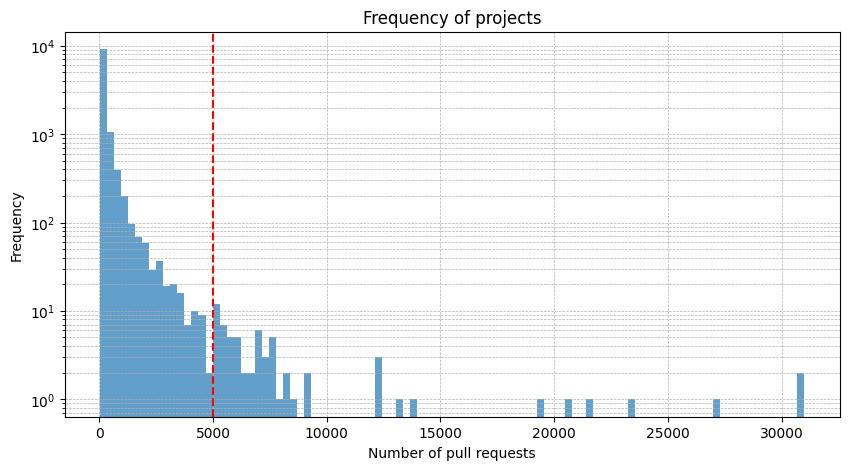

Mean number of pull requests: 298.12439893143363
Median number of pull requests: 96.0
Standard deviation of pull requests: 919.5069983233892
Maximum number of pull requests: 31007
Minimum number of pull requests: 20
Number of project with more than 5000 pull requests: 64


In [7]:
num_projects = data['project_id'].unique()
print('Number of projects: {}'.format(len(num_projects)))

projects = data['project_id'].value_counts()
project_ids = projects.index
num_pull_requests = projects.values

plt.figure(figsize=(10, 5))
plt.hist(num_pull_requests, bins=100, alpha=0.7, log=True)
plt.axvline(x=5000, color='r', linestyle='--')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.title('Frequency of projects')
plt.xlabel('Number of pull requests')
plt.ylabel('Frequency')
plt.show()

print('Mean number of pull requests: {}'.format(np.mean(num_pull_requests)))
print('Median number of pull requests: {}'.format(np.median(num_pull_requests)))
print('Standard deviation of pull requests: {}'.format(np.std(num_pull_requests)))
print('Maximum number of pull requests: {}'.format(np.max(num_pull_requests)))  
print('Minimum number of pull requests: {}'.format(np.min(num_pull_requests)))

print('Number of project with more than 5000 pull requests: {}'.format(len(projects[num_pull_requests > 5000])))
filtered_project_ids_pr = projects[num_pull_requests > 5000].index

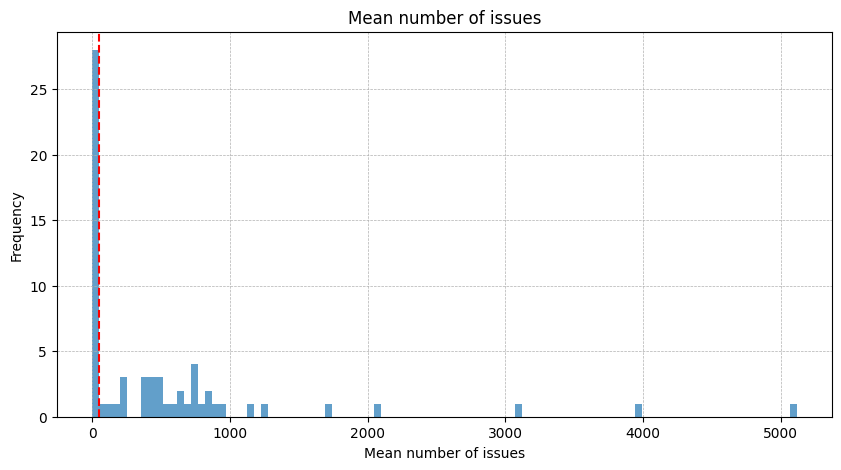

Mean number of issues: 533.6983378572712
Median number of issues: 223.95945367728729
Standard deviation of issues: 913.7737525230855
Maximum number of issues: 5114.82380743556
Minimum number of issues: 0.0
Number of project with more than 50 issues: 36


In [8]:
opened_issues = data[data['project_id'].isin(filtered_project_ids_pr)].groupby('project_id')['open_issue_num'].mean()

plt.figure(figsize=(10, 5))
plt.hist(opened_issues, bins=100, alpha=0.7)
plt.axvline(x=50, color='r', linestyle='--')
plt.xlabel('Mean number of issues')
plt.ylabel('Frequency')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.title('Mean number of issues')
plt.show()

print('Mean number of issues: {}'.format(np.mean(opened_issues)))
print('Median number of issues: {}'.format(np.median(opened_issues)))
print('Standard deviation of issues: {}'.format(np.std(opened_issues)))
print('Maximum number of issues: {}'.format(np.max(opened_issues)))
print('Minimum number of issues: {}'.format(np.min(opened_issues)))

filtered_project_ids_issue = opened_issues[opened_issues > 50].index
print('Number of project with more than 50 issues: {}'.format(len(filtered_project_ids_issue)))

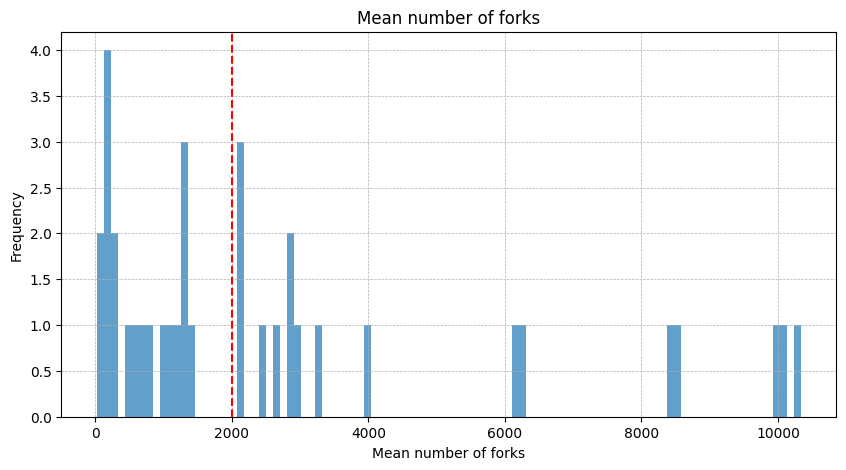

Mean number of forks: 2770.902336516114
Median number of forks: 1392.0325528649205
Standard deviation of number of forks: 3138.607774676715
Max number of forks: 10339.12191200117
Min number of forks: 17.9272476340694
Number of project with more than 2000 forks: 17


In [9]:
forks = data[data['project_id'].isin(filtered_project_ids_issue)].groupby('project_id')['fork_num'].mean()
plt.figure(figsize=(10, 5))
plt.hist(forks, bins=100, alpha=0.7)
plt.axvline(x=2000, color='r', linestyle='--')
plt.xlabel('Mean number of forks')
plt.ylabel('Frequency')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.title('Mean number of forks')
plt.show()

print('Mean number of forks: {}'.format(forks.mean()))
print('Median number of forks: {}'.format(forks.median()))
print('Standard deviation of number of forks: {}'.format(forks.std()))
print('Max number of forks: {}'.format(forks.max()))
print('Min number of forks: {}'.format(forks.min()))

filtered_project_ids_forks = forks[forks > 2000].index
print('Number of project with more than 2000 forks: {}'.format(len(filtered_project_ids_forks)))

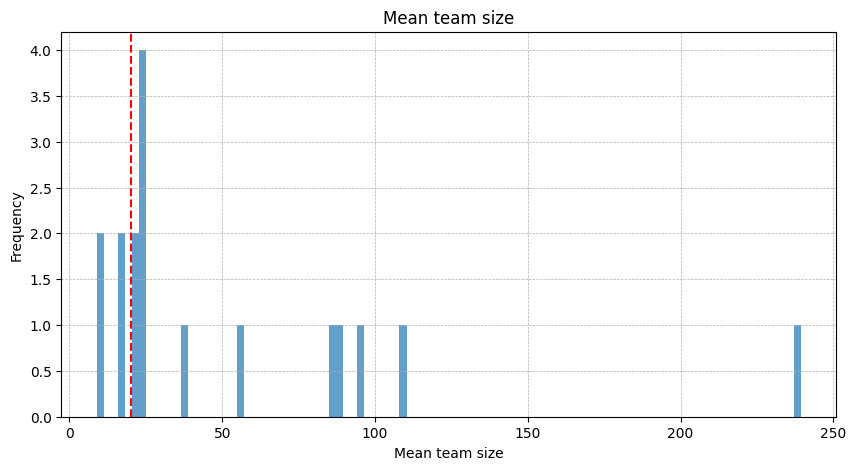

Mean team size: 53.18557840391017
Median team size: 24.21525700299157
Standard deviation: 58.21667776231618
Minimum team size: 8.850659264399722
Maximum team size: 239.44101739511768
More than 20 collaborators: 13


In [10]:

num_collaborators = data[data['project_id'].isin(filtered_project_ids_forks)].groupby('project_id')['team_size'].mean()

plt.figure(figsize=(10, 5))
plt.hist(num_collaborators, bins=100, alpha=0.7)
plt.axvline(x=20, color='r', linestyle='--')
plt.xlabel('Mean team size')
plt.ylabel('Frequency')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.title('Mean team size')
plt.show()

print('Mean team size: {}'.format(num_collaborators.mean()))
print('Median team size: {}'.format(num_collaborators.median()))
print('Standard deviation: {}'.format(num_collaborators.std()))
print('Minimum team size: {}'.format(num_collaborators.min()))
print('Maximum team size: {}'.format(num_collaborators.max()))

filtered_project_ids_collab = num_collaborators[num_collaborators > 20].index
print('More than 20 collaborators: {}'.format(len(filtered_project_ids_collab)))


## Analysis of filtered data

In [11]:
print(data[data['project_id'].isin(filtered_project_ids_collab)]['reponame'].unique())
filtered_data = data[data['project_id'].isin(filtered_project_ids_collab)]
filtered_data

['scikit-learn' 'salt' 'metasploit-framework' 'kubernetes' 'react' 'node'
 'ansible' 'odoo' 'rails' 'matplotlib' 'ember.js' 'pandas' 'gatsby']


,id,project_id,ownername,reponame,merged_or_not,lifetime_minutes,mergetime_minutes,num_commits,src_churn,test_churn,...,other_comment,num_comments_con,num_code_comments,num_code_comments_con,integrator_availability,friday_effect,contrib_rate_author,reopen_or_not,first_close_minutes,reopen_num
30,31,5219,scikit-learn,scikit-learn,0,122459,NaN,3,201,504,...,1,8,199,2,60.0,0,0.000373,0,122459,0
34,35,1142,saltstack,salt,1,4534,4534.0,1,22,0,...,0,1,0,0,49.0,1,0.000622,0,4534,0
40,41,1142,saltstack,salt,1,983,983.0,1,193,0,...,0,0,0,0,3.0,0,0.000013,0,983,0
44,45,853,rapid7,metasploit-framework,1,131,131.0,1,2,0,...,0,0,0,0,159.0,0,0.000023,0,131,0
51,52,22091370,kubernetes,kubernetes,1,627,627.0,1,8,19,...,1,3,0,0,0.0,0,0.000459,0,627,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3347814,3347815,48212908,pandas-dev,pandas,1,63531,63531.0,215,9804,13464,...,1,13,17,3,7.0,0,0.000274,1,10204,1
3347881,3347882,20078281,nodejs,node,1,11373,11373.0,4,16,0,...,1,9,0,0,197.0,0,0.012812,0,11373,0
3347882,3347883,853,rapid7,metasploit-framework,1,1248,1248.0,4,66,0,...,0,1,2,0,113.0,0,0.001935,0,1248,0
3347907,3347908,3905191,facebook,react,1,484,484.0,1,0,0,...,1,0,0,0,12.0,0,0.097158,0,484,0


/tmp/ipykernel_12043/1676132540.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['log_mergetime_minutes'] = np.log(filtered_data['mergetime_minutes'] + 1)


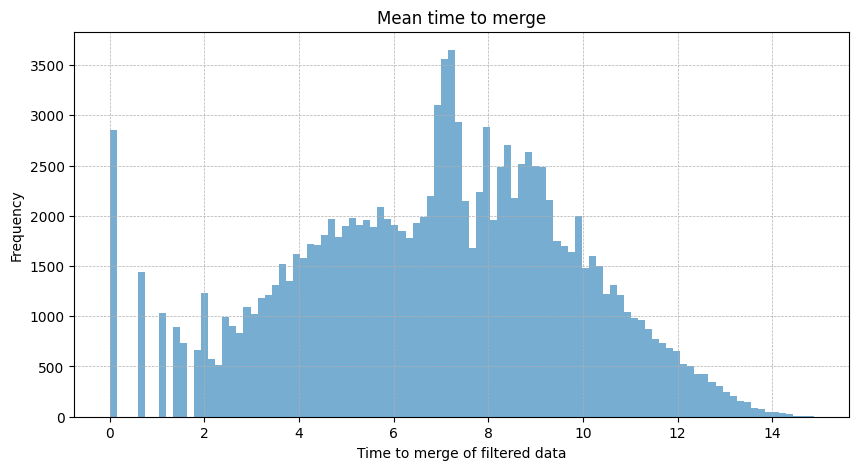

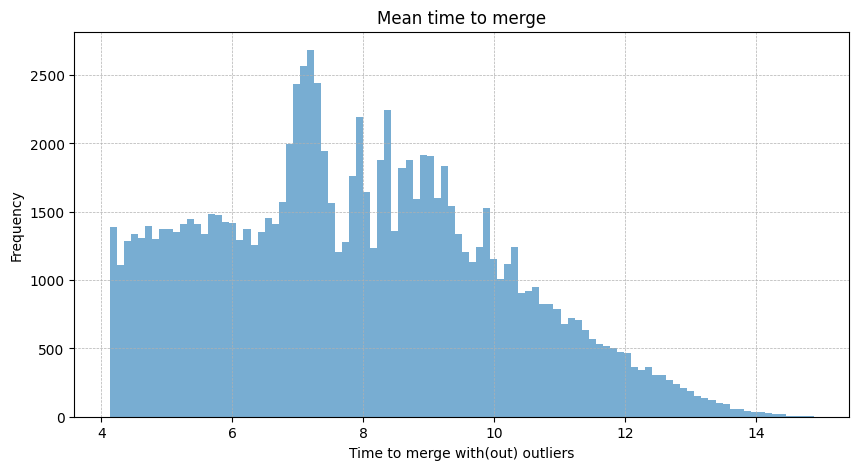

Number of pull requests before removing outliers: 186705
Number of pull requests after removing outliers: 104369


In [12]:
filtered_data['log_mergetime_minutes'] = np.log(filtered_data['mergetime_minutes'] + 1)
# filtered_df['filtered_mergetime_minutes'] = np.exp(filtered_df['log_mergetime_minutes']) - 1

plt.figure(figsize=(10, 5))
plt.hist(filtered_data['log_mergetime_minutes'], bins=100, alpha=0.6)
plt.xlabel('Time to merge of filtered data')
plt.ylabel('Frequency')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.title('Mean time to merge')
plt.show()

Q1 = filtered_data['log_mergetime_minutes'].quantile(0.25)
Q3 = filtered_data['log_mergetime_minutes'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

merged_data = filtered_data[(filtered_data['log_mergetime_minutes'] >= lower_bound) & (filtered_data['log_mergetime_minutes'] <= upper_bound)]
merged_data = merged_data[merged_data['mergetime_minutes'] > 60]

plt.figure(figsize=(10, 5))
plt.hist(merged_data['log_mergetime_minutes'], bins=100, alpha=0.6)
plt.xlabel('Time to merge with(out) outliers')
plt.ylabel('Frequency')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.title('Mean time to merge')
plt.show()

print('Number of pull requests before removing outliers: {}'.format(len(filtered_data)))
print('Number of pull requests after removing outliers: {}'.format(len(merged_data)))



## Shapiro-Wilk
The Shapiro-Wilk test tests the null hypothesis that the data was drawn from a normal distribution.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html


## Spearman
The Spearman correlation is a nonparametric measure of the linear relationship between two datasets. Unlike the Pearson correlation, the Spearman correlation does not assume that both datasets are normally distributed. Like other correlation coefficients, this one varies between -1 and +1 with 0 implying no correlation. Correlations of -1 or +1 imply a monotonic relationship. Positive correlations imply that as x increases, so does y. Negative correlations imply that as x increases, y decreases.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mstats.spearmanr.html#scipy.stats.mstats.spearmanr

## Kendall tau
Kendall’s tau is a measure of the correspondence between two rankings. Values close to 1 indicate strong agreement, and values close to -1 indicate strong disagreement. This implements two variants of Kendall’s tau: tau-b (the default) and tau-c (also known as Stuart’s tau-c). These differ only in how they are normalized to lie within the range -1 to 1; the hypothesis tests (their p-values) are identical. Kendall’s original tau-a is not implemented separately because both tau-b and tau-c reduce to tau-a in the absence of ties.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kendalltau.html

## Mann-Whitney U
The Mann-Whitney U test is a nonparametric test of the null hypothesis that the distribution underlying sample x is the same as the distribution underlying sample y. It is often used as a test of difference in location between distributions.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html

# Gender

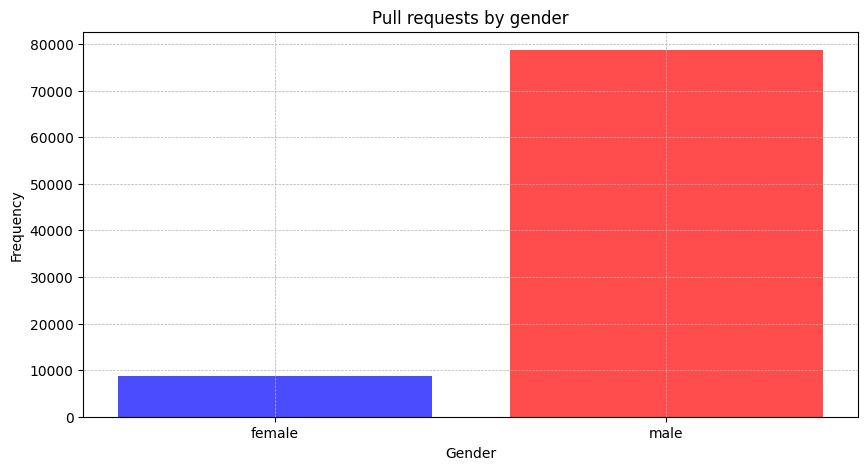

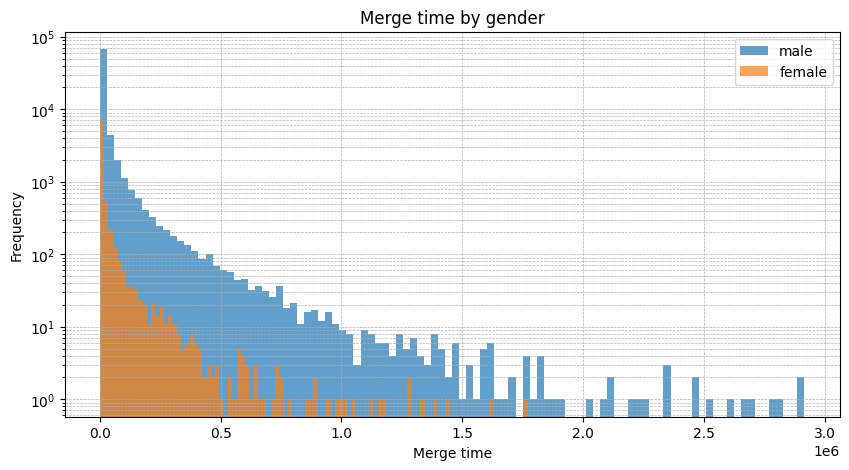

Shapiro-Wilk test for male contributors: W = 0.24147728607886176, p = 2.028558050475086e-89
Shapiro-Wilk test for female contributors: W = 0.22603752277642808, p = 7.012046674574992e-90
Kruskal-Wallis H test: H = 83.60279170075836, p = 6.048758738105603e-20
Mean merge time for male contributors: 26091.017105313324
Mean merge time for female contributors: 19714.80679847381
Median merge time for male contributors: 2265.0
Median merge time for female contributors: 1602.0
Standard deviation of merge time for male contributors: 99870.90329074685
Standard deviation of merge time for female contributors: 79737.3115666585
Maximum merge time for male contributors: 2916770.0
Maximum merge time for female contributors: 1768570.0
Minimum merge time for male contributors: 61.0
Minimum merge time for female contributors: 61.0


In [13]:
gender = merged_data['contrib_gender'].value_counts().sort_index()

plt.figure(figsize=(10, 5))
plt.bar(gender.index, gender.values, alpha=0.7, color=['blue', 'red'])
plt.xticks(gender.index, ['female', 'male'])
plt.xlabel('Gender')
plt.ylabel('Frequency')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.title('Pull requests by gender')
plt.show()

male = merged_data[merged_data['contrib_gender'] == 'male']
female = merged_data[merged_data['contrib_gender'] == 'female']

plt.figure(figsize=(10, 5))
plt.hist(male['mergetime_minutes'], bins=100, alpha=0.7, label='male', log=True)
plt.hist(female['mergetime_minutes'], bins=100, alpha=0.7, label='female', log=True)
plt.xlabel('Merge time')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.title('Merge time by gender')
plt.show()

sample_size = 5000
male_sample = male['mergetime_minutes'].sample(n=sample_size, random_state=1)
female_sample = female['mergetime_minutes'].sample(n=sample_size, random_state=1)

res_male = shapiro(male_sample)
res_female = shapiro(female_sample)
print('Shapiro-Wilk test for male contributors: W = {}, p = {}'.format(res_male.statistic, res_male.pvalue))
print('Shapiro-Wilk test for female contributors: W = {}, p = {}'.format(res_female.statistic, res_female.pvalue))

# Perform Kruskal-Wallis H test
H, p = kruskal(male['mergetime_minutes'], female['mergetime_minutes'])

print('Kruskal-Wallis H test: H = {}, p = {}'.format(H, p))


print('Mean merge time for male contributors: {}'.format(male['mergetime_minutes'].mean()))
print('Mean merge time for female contributors: {}'.format(female['mergetime_minutes'].mean()))
print('Median merge time for male contributors: {}'.format(male['mergetime_minutes'].median()))
print('Median merge time for female contributors: {}'.format(female['mergetime_minutes'].median()))
print('Standard deviation of merge time for male contributors: {}'.format(male['mergetime_minutes'].std()))
print('Standard deviation of merge time for female contributors: {}'.format(female['mergetime_minutes'].std()))
print('Maximum merge time for male contributors: {}'.format(male['mergetime_minutes'].max()))
print('Maximum merge time for female contributors: {}'.format(female['mergetime_minutes'].max()))
print('Minimum merge time for male contributors: {}'.format(male['mergetime_minutes'].min()))
print('Minimum merge time for female contributors: {}'.format(female['mergetime_minutes'].min()))

# Country

# Affiliation

# Team dynamics